In [ ]:
import numpy as np
import os
import time
import copy
import matplotlib.pyplot as plt
import torch
from save_utils import save_checkpoint, load_checkpoint
from train_utils import train_model

%load_ext autoreload
%autoreload 2

os.environ['KMP_DUPLICATE_LIB_OK']='True' # To prevent the kernel from dying.

In [3]:
lth_ecg_checkpoint = load_checkpoint("lth_ecg_checkpoint.pth")

lth_ecg_step = lth_ecg_checkpoint['step']
lth_ecg_pruning_percentage = lth_ecg_checkpoint['pruning_percentage']
lth_ecg_current_mask = lth_ecg_checkpoint['current_mask']
lth_ecg_history_theta = lth_ecg_checkpoint['history_theta']
lth_ecg_history_f1 = lth_ecg_checkpoint['history_f1']
lth_ecg_history_sparsity = lth_ecg_checkpoint['history_sparsity']
lth_ecg_layerwise_remaining_params = lth_ecg_checkpoint["layerwise_remaining_params"]

--> Checkpoint loading : lth_ecg_checkpoint.pth


In [4]:
it_pru_checkpoint = load_checkpoint("iterative_pruning_weight_rewinding_True_checkpoint.pth")

it_pru_step = it_pru_checkpoint['step']
it_pru_pruning_percentage = it_pru_checkpoint['pruning_percentage']
it_pru_current_mask = it_pru_checkpoint['current_mask']
it_pru_history_theta = it_pru_checkpoint['history_theta']
it_pru_history_f1 = it_pru_checkpoint['history_f1']
it_pru_history_sparsity = it_pru_checkpoint['history_sparsity']
it_pru_layerwise_remaining_params = it_pru_checkpoint["layerwise_remaining_params"]

--> Checkpoint loading : iterative_pruning_weight_rewinding_True_checkpoint.pth


In [5]:
it_pru_no_rew_checkpoint = load_checkpoint("iterative_pruning_weight_rewinding_False_checkpoint.pth")

it_pru_no_rew_step = it_pru_no_rew_checkpoint['step']
it_pru_no_rew_pruning_percentage = it_pru_no_rew_checkpoint['pruning_percentage']
it_pru_no_rew_current_mask = it_pru_no_rew_checkpoint['current_mask']
it_pru_no_rew_history_theta = it_pru_no_rew_checkpoint['history_theta']
it_pru_no_rew_history_f1 = it_pru_no_rew_checkpoint['history_f1']
it_pru_no_rew_history_sparsity = it_pru_no_rew_checkpoint['history_sparsity']
it_pru_no_rew_layerwise_remaining_params = it_pru_no_rew_checkpoint["layerwise_remaining_params"]

--> Checkpoint loading : iterative_pruning_weight_rewinding_False_checkpoint.pth


In [ ]:
def to_theta(s) : 
    s = np.array(s) 
    return 1/(1-s)

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(to_theta(lth_ecg_history_sparsity), lth_ecg_history_f1, color='r',linestyle='-', marker='.', markersize=4,
         label='LTH-ECG (Trained & pruned model)')
plt.plot(to_theta(it_pru_history_sparsity), it_pru_history_f1, color='b',linestyle='-', marker='.', markersize=4,
         label='Iterative pruning (Franckle & Carbin)')
plt.plot(to_theta(it_pru_no_rew_history_sparsity), it_pru_no_rew_history_f1, color='g',linestyle='-', marker='.', markersize=4,
         label='Iterative pruning with no weight rewinding (Franckle & Carbin)')

plt.axhline(y=0.836, color='black', linestyle='--', label='Benchmark Model score Hannun et al. (0.836)')
plt.axhline(y=0.827, color='gray', linestyle=':', label='1% Tolerance drop (0.827)')
plt.xlabel('Parameter reduction factor ($\\theta$)') 
plt.ylabel('Test mean F1-score')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.ylim(0, 0.95)
plt.legend(loc='lower left')
plt.show()

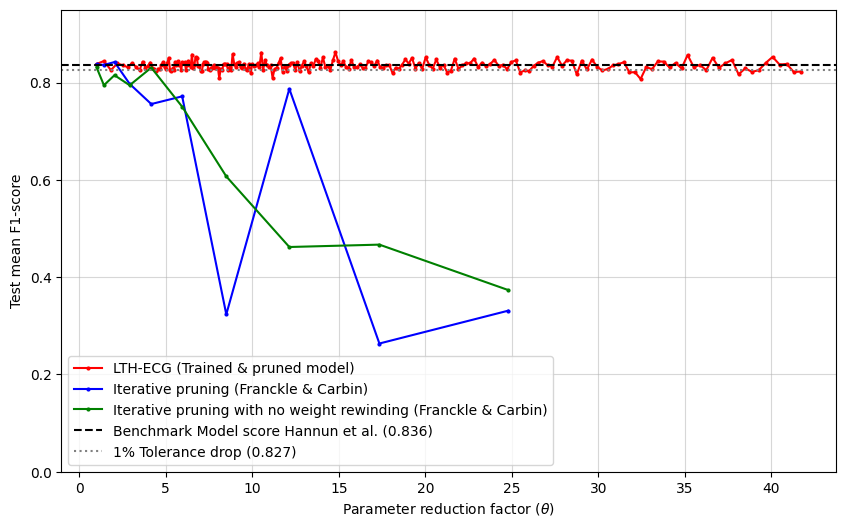

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(lth_ecg_history_theta, lth_ecg_history_f1, color='r',linestyle='-', marker='.', markersize=4,
         label='LTH-ECG (Trained & pruned model)')
plt.plot(it_pru_history_theta, it_pru_history_f1, color='b',linestyle='-', marker='.', markersize=4,
         label='Iterative pruning (Franckle & Carbin)')
plt.plot(it_pru_no_rew_history_theta, it_pru_no_rew_history_f1, color='g',linestyle='-', marker='.', markersize=4,
         label='Iterative pruning with no weight rewinding (Franckle & Carbin)')

plt.axhline(y=0.836, color='black', linestyle='--', label='Benchmark Model score Hannun et al. (0.836)')
plt.axhline(y=0.827, color='gray', linestyle=':', label='1% Tolerance drop (0.827)')
plt.xlabel('Parameter reduction factor ($\\theta$)') 
plt.ylabel('Test mean F1-score')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.ylim(0, 0.95)
plt.legend(loc='lower left')
plt.show()

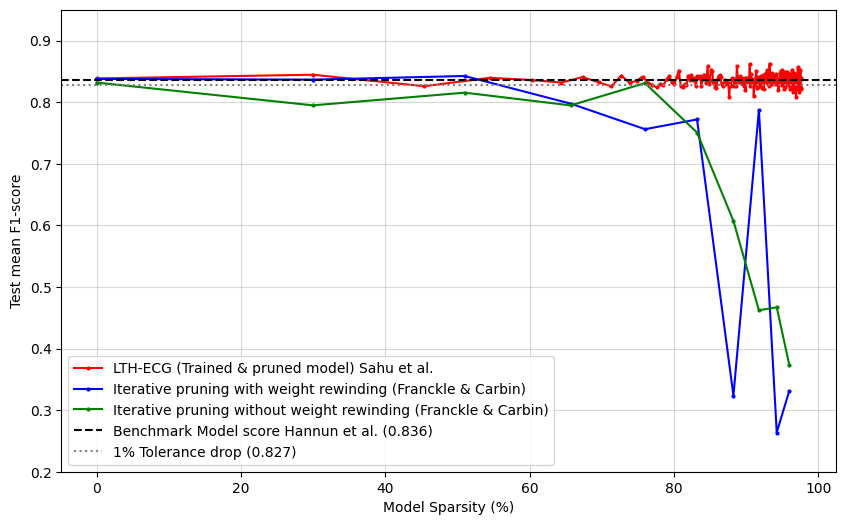

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(np.array(lth_ecg_history_sparsity)*100, lth_ecg_history_f1, color='r',linestyle='-', marker='.', markersize=4,
label='LTH-ECG (Trained & pruned model) Sahu et al.')

plt.plot(np.array(it_pru_history_sparsity)*100, it_pru_history_f1, color='b',linestyle='-', marker='.', markersize=4,
label='Iterative pruning with weight rewinding (Franckle & Carbin)')

plt.plot(np.array(it_pru_no_rew_history_sparsity)*100, it_pru_no_rew_history_f1, color='g',linestyle='-', marker='.', markersize=4,
label='Iterative pruning without weight rewinding (Franckle & Carbin)')

plt.axhline(y=0.836, color='black', linestyle='--', label='Benchmark Model score Hannun et al. (0.836)')
plt.axhline(y=0.827, color='gray', linestyle=':', label='1% Tolerance drop (0.827)')
plt.xlabel('Model Sparsity (%)') 
plt.ylabel('Test mean F1-score')
plt.grid(True, which="both", ls="-", alpha=0.5)
plt.ylim(0.2, 0.95)
plt.legend(loc='lower left')
plt.show()

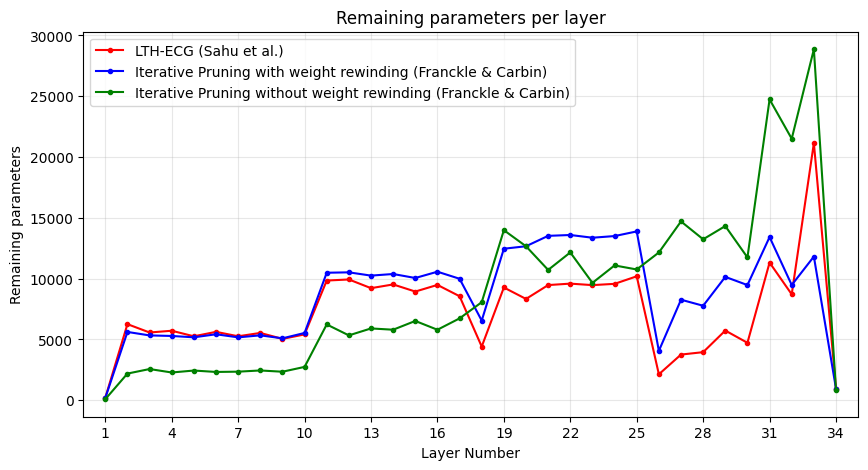

In [ ]:
ordered_layer_names =['first_block_conv.conv.weight', 'basicblock_list.0.conv1.conv.weight',
                    'basicblock_list.0.conv2.conv.weight', 'basicblock_list.1.conv1.conv.weight', 
                    'basicblock_list.1.conv2.conv.weight', 'basicblock_list.2.conv1.conv.weight', 
                    'basicblock_list.2.conv2.conv.weight', 'basicblock_list.3.conv1.conv.weight', 
                    'basicblock_list.3.conv2.conv.weight', 'basicblock_list.4.conv1.conv.weight', 
                    'basicblock_list.4.conv2.conv.weight', 'basicblock_list.5.conv1.conv.weight', 
                    'basicblock_list.5.conv2.conv.weight', 'basicblock_list.6.conv1.conv.weight', 
                    'basicblock_list.6.conv2.conv.weight', 'basicblock_list.7.conv1.conv.weight', 
                    'basicblock_list.7.conv2.conv.weight', 'basicblock_list.8.conv1.conv.weight', 
                    'basicblock_list.8.conv2.conv.weight', 'basicblock_list.9.conv1.conv.weight',
                    'basicblock_list.9.conv2.conv.weight', 'basicblock_list.10.conv1.conv.weight', 
                    'basicblock_list.10.conv2.conv.weight', 'basicblock_list.11.conv1.conv.weight', 
                    'basicblock_list.11.conv2.conv.weight', 'basicblock_list.12.conv1.conv.weight', 
                    'basicblock_list.12.conv2.conv.weight', 'basicblock_list.13.conv1.conv.weight', 
                    'basicblock_list.13.conv2.conv.weight', 'basicblock_list.14.conv1.conv.weight', 
                    'basicblock_list.14.conv2.conv.weight', 'basicblock_list.15.conv1.conv.weight', 
                    'basicblock_list.15.conv2.conv.weight','dense.weight']


x_indices_lth_ecg , y_values_lth_ecg = [], []

x_values_it_pru, y_values_it_pru = [], []

x_values_it_pru_no_rew, y_values_it_pru_no_rew = [], []

# check if the layer order is correct
for i, name in enumerate(ordered_layer_names):
    if name in lth_ecg_layerwise_remaining_params:
        y_values_lth_ecg.append(lth_ecg_layerwise_remaining_params[name])
        x_indices_lth_ecg.append(i + 1)

for i, name in enumerate(ordered_layer_names):
    if name in it_pru_layerwise_remaining_params:
        y_values_it_pru.append(it_pru_layerwise_remaining_params[name])
        x_values_it_pru.append(i + 1) 

for i, name in enumerate(ordered_layer_names):
    if name in it_pru_no_rew_layerwise_remaining_params:
        y_values_it_pru_no_rew.append(it_pru_no_rew_layerwise_remaining_params[name])
        x_values_it_pru_no_rew.append(i + 1)

plt.figure(figsize=(10, 5))

plt.plot(x_indices_lth_ecg, y_values_lth_ecg, color='r', marker='.', label='LTH-ECG (Sahu et al.)')
plt.plot(x_values_it_pru, y_values_it_pru, color='b', marker='.', label='Iterative Pruning with weight rewinding (Franckle & Carbin)')
plt.plot(x_values_it_pru_no_rew, y_values_it_pru_no_rew, color='g', marker='.', label='Iterative Pruning without weight rewinding (Franckle & Carbin)')

plt.xlabel('Layer Number') 
plt.ylabel("Remaining parameters") 
plt.title("Remaining parameters per layer")

plt.xlim(0, 35)
plt.xticks(np.arange(1, 35, step=3))

plt.grid(True, alpha=0.3)
plt.legend()

In [ ]:
checkpoint = load_checkpoint("lth_ecg_checkpoint.pth")
step = checkpoint['step']
pruning_percentage = checkpoint['pruning_percentage']
current_mask = checkpoint['current_mask']
history_theta = checkpoint['history_theta']
history_f1 = checkpoint['history_f1']
history_sparsity = checkpoint['history_sparsity']
remaining_weights_number = sum(v.sum().item() for v in current_mask.values())
# On recharge les poids initiaux pour garantir le "Winning Ticket" 
model.load_state_dict(checkpoint['initial_weights'])
# On repart du modèle tel qu'il était avant le crash
sparse_model = PrunedModel(model=copy.deepcopy(model), mask=current_mask).to(device)

--> Chargement du checkpoint : lth_ecg_checkpoint.pth


In [ ]:
prior = calculate_priors(train_loader,device,4,500).to(device)

In [ ]:
trained_sparse_model, best_f1_val, f1_through_training_sparse = train_model(sparse_model, train_loader, val_loader, loss_func, device, prior=prior, epochs=20)

Validation Epoch [1/20]: 100%|████████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.39it/s, f1_val=0.8306, val_loss=0.56965245]


[Early Stopping] F1 Val (0.8306) >= 0.826. Fin de l'entraînement pour cette étape LTH.


In [ ]:
current_mask.sparsity

tensor(0.9763)

In [ ]:
trained_model_full, best_f1_val, f1_through_training_full = train_model(model, train_loader, val_loader, loss_func, tb_logger=None, prior=prior, epochs=20)


Validation Epoch [12/20]: 100%|███████████████████████████████████████████████████| 27/27 [00:02<00:00, 12.27it/s, f1_val=0.8329, val_loss=0.48120344]


[Early Stopping] F1 Val (0.8329) >= 0.826. Fin de l'entraînement pour cette étape LTH.


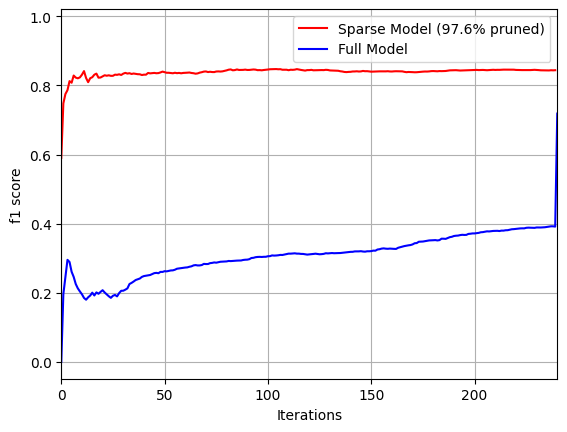

In [ ]:
x_lim = min(len(f1_through_training_sparse), len(f1_through_training_full))
plt.plot(f1_through_training_sparse,'r-',label = f'Sparse Model (97.6% pruned)')
plt.plot(f1_through_training_full,'b-', label = f'Full Model')
plt.xlim(0,x_lim)
#plt.xscale('log')
plt.xlabel('Iterations')
plt.ylabel('f1 score')
plt.grid()
plt.legend()
plt.show()